In [61]:
from core import *
import matplotlib.pyplot as plt

# Making a single/basic model ring

In [62]:
a = 51149 #km
e = 0.5
i = 80.0
omega = 60.0
w = 30.
imsize = 300 #px
pixscale = 500 #km/px

In [63]:
ringmodel = Ring(a, e, omega, i, w)
img = ringmodel.as_2d_array((imsize, imsize), pixscale) #shape (pixels), pixscale (km)

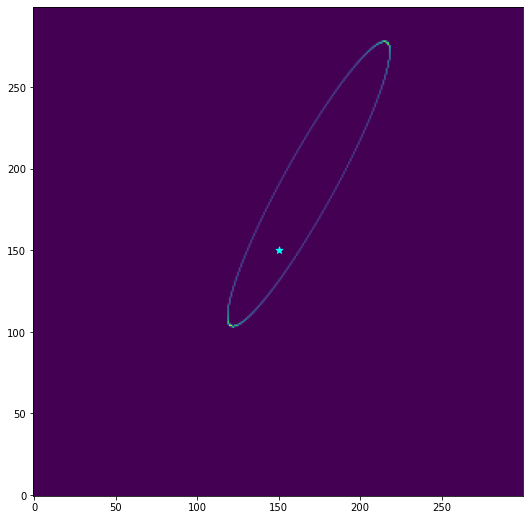

In [64]:
fig, ax = plt.subplots(1,1, figsize = (9,9))

ax.imshow(img, origin = 'lower')
ax.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')
plt.savefig('example_epsilon_ring.png')
plt.show()

this is still wrong. try changing omega from 0 to 90 with i = 0, w = 0, e = 0.5. shouldn't this have no effect whatsoever? and yet it does have an effect?

## giving rings width and brightness

of course, real rings are not infinitesimal mathematical constructs. they have width, and in an astronomical context, they also have surface brightness. Note here that we can also modify the ring properties in place, but we must specify Astropy units when doing so.

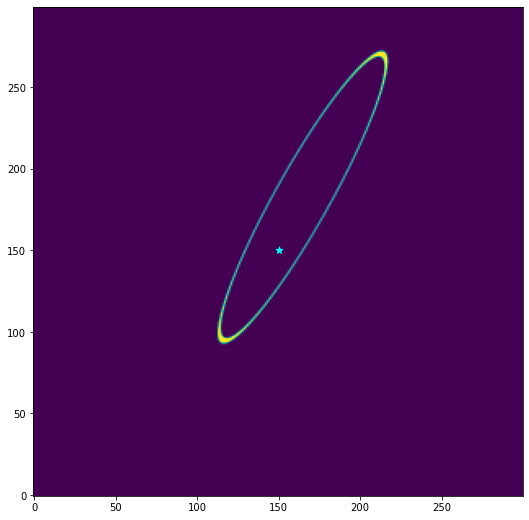

In [65]:
# to do: add a colorbar here!
ringmodel2 = Ring(a, 0.01, omega, i, w, flux = 0.001, width = 500)
ringmodel2.e = 0.4
ringmodel2.width = 2000*u.km
img = ringmodel2.as_2d_array((imsize, imsize), pixscale) #shape (pixels), pixscale (km)
fig, ax = plt.subplots(1,1, figsize = (9,9))

ax.imshow(img, origin = 'lower')
ax.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')
plt.savefig('example_epsilon_ring.png')
plt.show()

## using ring objects as masks

suppose we wanted to extract the flux from a real image in an annulus defined by the ring above. this is easily done, because under the hood, these rings are photutils.EllipticalAnnulus objects. We can simply say,

In [66]:
ann = ringmodel2.as_elliptical_annulus((imsize, imsize), pixscale)
print(type(ann))

<class 'photutils.aperture.ellipse.EllipticalAnnulus'>


TO ADD HERE: real example of extracting flux from ring

## convolving with a beam

we can also define an elliptical beam to convolve with as we cast into a 2-D array

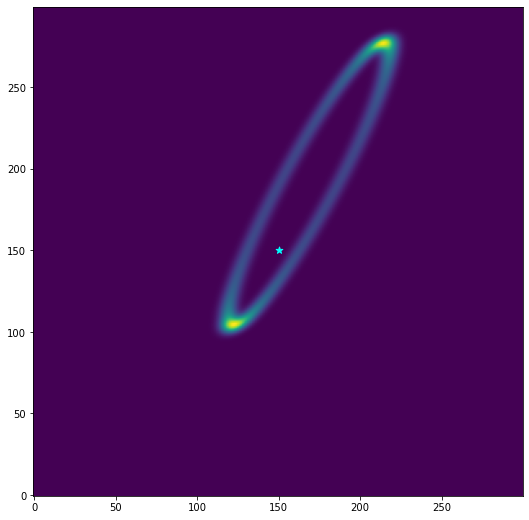

In [67]:
img = ringmodel.as_2d_array((imsize, imsize), pixscale, beamsize = (10,6,30*u.degree))

fig, ax = plt.subplots(1,1, figsize = (9,9))

ax.imshow(img, origin = 'lower')
ax.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')
plt.savefig('example_epsilon_ring.png')
plt.show()

# Model ring system observation

the RingSystemModelObservation tool makes mock observations of rings. It contains a static data table of ring properties for Jupiter, Saturn, Uranus, and Neptune. It interfaces with the Planetary Ring Node query tool and the JPL Horizons query tool to make the proper projected geometry for a given time of observation. The end result is basically a fully-editable Python version of the Planetary Ring Node.  Here is an example of a simple query:

In [133]:
epoch = '2020-01-30 00:00'
alma_coords = ( -67.755 * u.deg, -23.029 * u.deg, 5000 * u.m) #lon, lat, alt(m)
ringnames = ['Six', 'Five', 'Four', 'Alpha', 'Beta', 'Eta', 'Gamma', 'Delta', 'Epsilon']

In [69]:
epoch_astropy = Time(epoch, format = 'iso', scale = 'utc')
alma_coords_astropy = EarthLocation(alma_coords[0], alma_coords[1], alma_coords[2])
    
uranus_rings = RingSystemModelObservation('uranus',
                     epoch=epoch_astropy,
                     location = alma_coords_astropy,
                     ringnames = ringnames)
print(uranus_rings.rings['Epsilon'])

Ring instance; a=51149.0 km, e=0.00794, i=45.54283 deg, width=58.1 km


The model observation has made Ring objects for each ring in ringnames. All the properties of Ring objects discussed above can be used here. Let's go ahead and plot the full model

In [70]:
pixscale = 300*u.km
imsize = 500

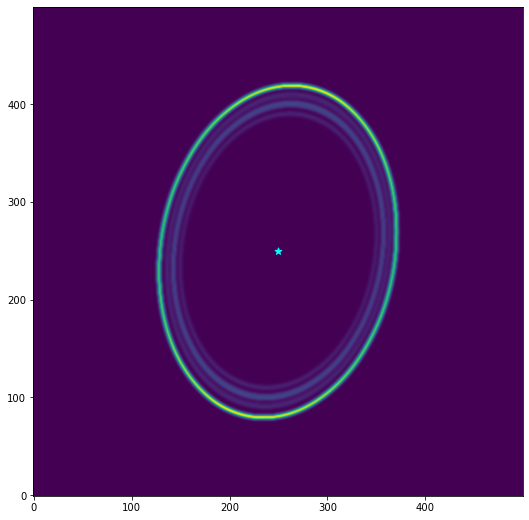

In [71]:
obs = uranus_rings.as_2d_array((imsize, imsize), pixscale, beamsize = (4,4,30*u.degree)) 
fig, ax = plt.subplots(1,1, figsize = (9,9))

ax.imshow(obs, origin = 'lower')
ax.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')
plt.show() 

Notice that we do not need to specify an image size or pixel scale until we have decided to cast the system into an array. This gives us more flexibility to modify things before plotting or comparing to observations

## modifying the defaults

sometimes we want something other than the default values for radius, eccentricity, etc., or to play with different ephemerides. In this case, we can simply modify the Ring objects directly before plotting.  Let's make the epsilon ring larger, and the alpha ring more eccentric

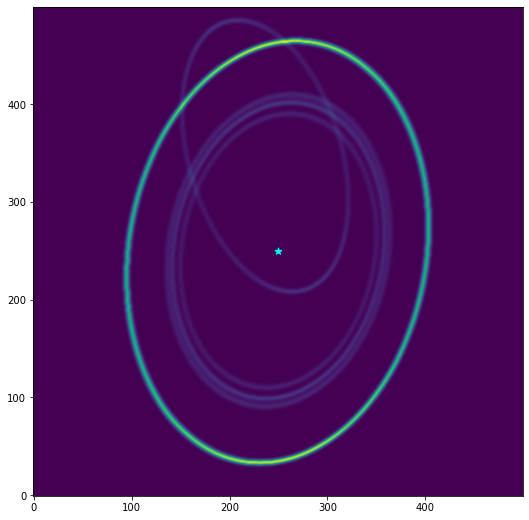

In [72]:
uranus_rings.rings['Epsilon'].a = 65000*u.km
uranus_rings.rings['Alpha'].e = 0.7
uranus_rings.rings['Alpha'].omega = 120*u.deg
obs = uranus_rings.as_2d_array((imsize, imsize), pixscale, beamsize = (5,4,30*u.degree)) 
fig, ax = plt.subplots(1,1, figsize = (9,9))

ax.imshow(obs, origin = 'lower')
ax.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')
plt.show() 

## support for minor rings

The static data tables loaded from the PDS support minor rings and dusty rings, too.

Ring instance; a=39600.0 km, e=0.0, i=45.54283 deg, width=3500.0 km


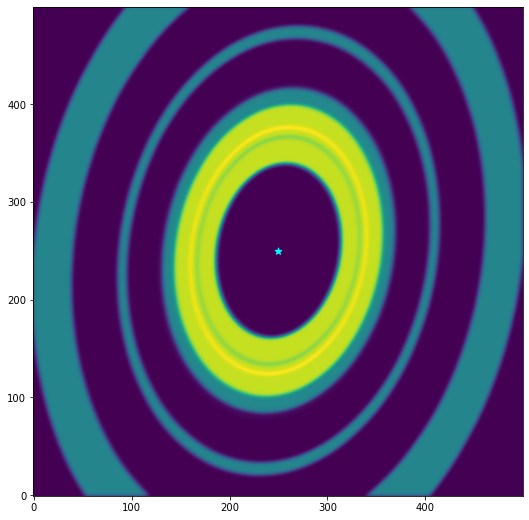

In [73]:
epoch_astropy = Time(epoch, format = 'iso', scale = 'utc')
alma_coords_astropy = EarthLocation(alma_coords[0], alma_coords[1], alma_coords[2])
    
uranus_rings_dusty = RingSystemModelObservation('uranus',
                     epoch=epoch_astropy,
                     location = alma_coords_astropy,
                     ringnames = None)

print(uranus_rings_dusty.rings['Zeta'])

obs = uranus_rings_dusty.as_2d_array((imsize, imsize), pixscale, beamsize = (5,4,30*u.degree)) 

fig, ax = plt.subplots(1,1, figsize = (9,9))

ax.imshow(obs, origin = 'lower')
ax.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')
plt.show() 

## modifying widths and fluxes

This image shows some weaknesses of the default behavior: for minor rings, the relative brightnesses and/or widths are very often incorrect due to a lack of good data. We can get around this either by modifying each Ring object after instantiating them, or by inputting a list of fluxes and/or widths as we instantiate the model, as shown here:

# Analysis with real data

Here, I show how these tools can be used to extract the azimuthal profile of the epsilon ring in Keck data

In [137]:
from astropy.io import fits
from astroquery.jplhorizons import Horizons
from datetime import datetime, timedelta

hdul = fits.open('data/fits/urh60.fits')
pixscale_arcsec = 0.009942 #arcsec, keck
keck_coords = (155.4744 * u.deg, 19.8264 * u.deg, 4145 * u.m) #lon, lat, alt(m)

header = hdul[0].header
data = hdul[0].data
obs_time = header['DATE-OBS'] + ' ' + header['EXPSTART'][:-4]
start_time = datetime.strptime(obs_time, '%Y-%m-%d %H:%M:%S')
end_time = start_time + timedelta(minutes=1)
epochs = {'start':obs_time, 'stop':end_time.strftime('%Y-%m-%d %H:%M:%S'), 'step':'1m'}
keck_coords_astropy = EarthLocation(keck_coords[0], keck_coords[1], keck_coords[2])

print(epochs)

# convert pixscale from arcsec to km
obj = Horizons(id='799', location='568', epochs=epochs) #Uranus, Keck
d_AU = obj.ephemerides()['r'][0]*u.au
dist = d_AU.to(u.km).value
pixscale = dist*np.tan(np.deg2rad(pixscale_arcsec/3600.))
print(pixscale)

# image size also from header
imsize = header['NAXIS1']
print(imsize)

{'start': '2019-10-28 08:50:50', 'stop': '2019-10-28 08:51:50', 'step': '1m'}
142.96198191918248
1024


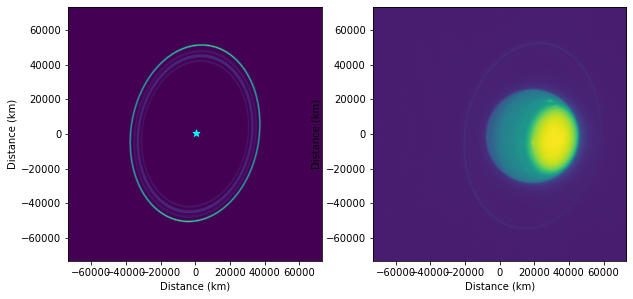

In [138]:
# make the model observation
uranus_rings = RingSystemModelObservation('uranus',
                     epoch=Time(start_time, scale='utc'),
                     location = alma_coords_astropy,
                     ringnames = ringnames)
model_keck_obs = uranus_rings.as_2d_array((imsize, imsize), pixscale, beamsize = (4,4,0*u.degree)) 

sz = pixscale*imsize
fig, [ax0, ax1] = plt.subplots(1,2, figsize = (10,6))

ax0.imshow(model_keck_obs, origin = 'lower', extent=[-sz/2, sz/2, -sz/2, sz/2])
ax0.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')

ax1.imshow(data, origin = 'lower', extent=[-sz/2, sz/2, -sz/2, sz/2])

for ax in [ax0, ax1]:
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Distance (km)')

plt.show()

Ring instance; a=51149.0 km, e=0.00794, i=43.76563 deg, width=58.1 km
[642.10451975 501.50770002]


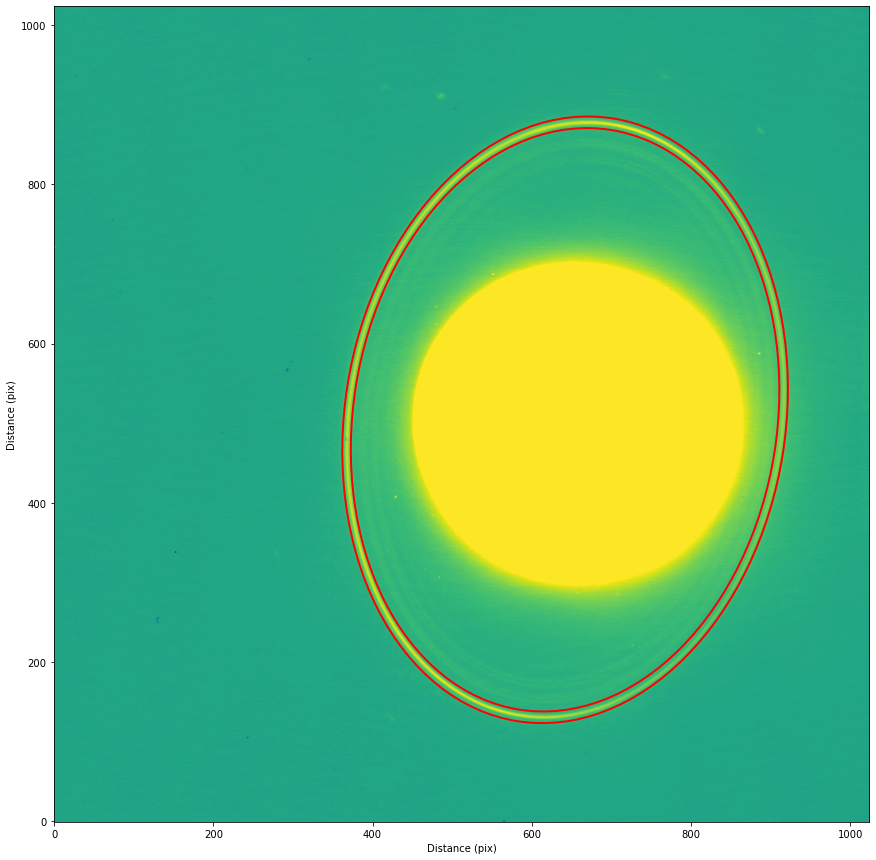

In [162]:
# They look to compare well. Now make the epsilon ring model into a photutils annulus
## follow up here: why did we need to change the size of the model by 5%?
arbitrary_scaling = 0.952
eps = uranus_rings.rings['Epsilon']
print(eps)
width = 2000*u.km
focus = np.array([18600, -1500])
focus = focus / pixscale + [imsize/2, imsize/2]
print(focus)
ann = eps.as_elliptical_annulus(focus, pixscale*arbitrary_scaling, width = width)

vmax = np.max(data)
sz = pixscale*imsize
fig, ax = plt.subplots(1,1, figsize = (15,15))

ax.imshow(data, origin = 'lower', vmax = vmax/16)#, extent=[-sz/2, sz/2, -sz/2, sz/2])
ann_patches = ann.plot(color='red', lw=2, label='epsilon')

ax.set_xlabel('Distance (pix)')
ax.set_ylabel('Distance (pix)')

plt.show()


In [166]:
# extract flux from epsilon ring (arbitrary units)
from photutils.aperture import ApertureStats
stats = ApertureStats(data, ann)
print(stats.to_table(['mean', 'median', 'std', 'var', 'sum']))

       mean            median             std                var               sum       
----------------- ---------------- ------------------ ----------------- -----------------
84.39910788108945 75.0458755493164 39.741247932314955 1579.366787217728 2114635.257203374


# Making a movie of the epsilon ring precession

As a nice example, and just for fun, here is how one would make an animation of the precession of the epsilon ring. I'm bumping the eccentricity of the ring up to 0.2 so you can see it visually; otherwise, this doesn't look like much!

The way I implemented this was to first make an initial model ring at the first time step. I then run many queries to ring node tool, each time saving the argument of periapsis of the epsilon ring. I make those a simple list, and then each time I plot, I just change the value of $\omega$ in the ring model and cast it into a 2-D array.

Note it would be just as easy, and more accurate (but slightly slower) to make a new RingSystemModelObservation for every time step. But the way I implemented it better showcases how a pre-existing ring model can be modified.


In [14]:
from datetime import datetime, timedelta
node = RingNode()
epoch_0 = datetime.strptime('2022-09-23 00:00', '%Y-%m-%d %H:%M')
wvals = []
for i in range(100): #eventually get to 100
    
    epoch = Time(epoch_0 + timedelta(days=5*i), scale='utc')
    bodytable, ringtable = node.ephemeris(planet='Uranus', epoch=epoch, location=alma_coords_astropy, cache=False)
    epsilon = ringtable[ringtable.loc_indices["Epsilon"]]
    w = epsilon['pericenter'].to(u.deg).value
    wvals.append(w)
    
wvals = np.asarray(wvals)
np.save('wvals.npy', wvals)

In [22]:
%%capture
wvals = np.load('wvals.npy')
beam = (4,3,30*u.degree)

# set up initial state
model0 = RingSystemModelObservation('uranus',
                     epoch=Time(epoch_0, scale='utc'),
                     location = alma_coords_astropy,
                     ringnames = ['Alpha','Epsilon'])
epsilon = model0.rings['Epsilon']
ringmodel = Ring(epsilon.a, 0.2, epsilon.omega, epsilon.i, epsilon.w)
img0 = ringmodel.as_2d_array((imsize, imsize), pixscale, beamsize = beam)

  
# set up the animation
import matplotlib.animation as animation

fig, ax = plt.subplots(1,1, figsize = (9,9))

im = ax.imshow(img0, origin = 'lower')
ax.scatter([img0.shape[0]/2],[img0.shape[1]/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')

# animation function.  This is called sequentially
def animate(i, wvals):
    '''progressively increase w'''
    ringmodel.w = wvals[i]*u.deg
    img = ringmodel.as_2d_array((imsize, imsize), pixscale, beamsize = (10,6,30*u.degree))
    a=im.get_array()
    a=img 
    im.set_array(a)
    return [im]

anim = animation.FuncAnimation(fig, animate, frames=len(wvals), fargs=(wvals,),
                              interval=100, blit=True)

anim.save('epsilon_precession.gif', fps=30)


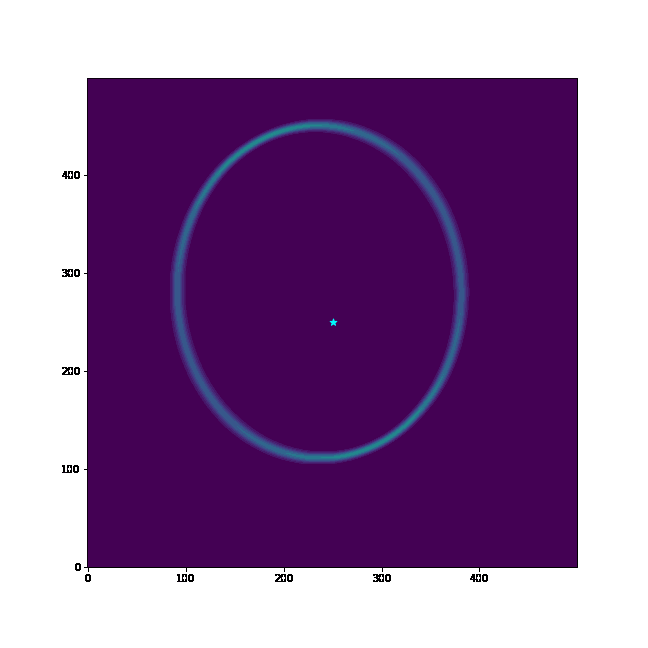

In [24]:
from IPython.display import Image
Image("epsilon_precession.gif", width=600, height=600)

# Loose ends / to-do list

- Why did I need to increase the size of the model epsilon ring by roughly 5%? Is this just a problem with how I defined the Keck pixel scale, or a bigger issue with the modeling?
- When using annulus for flux extraction, it might be a bad thing that the width changes as f(azimuth), because then you will have different fractions of the beam size extracted. Fix this by adding an option to Ring.as_elliptical_annulus
- 